In [305]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dataset = load_boston()

In [306]:
X = dataset.data
y = dataset.target

In [307]:
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [308]:
data = pd.DataFrame(np.c_[X, y], columns=np.hstack((dataset.feature_names, 'MEDV')))

## Общий анализ набора данных

### Гистограммы

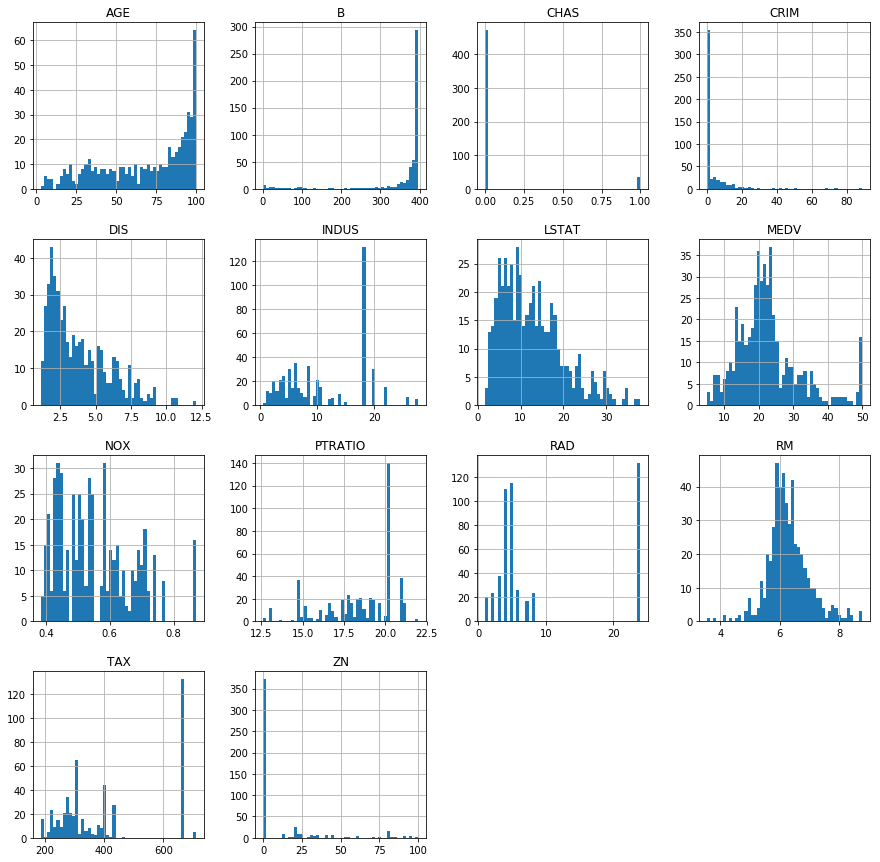

In [365]:
data.hist(figsize=(15,15), bins=50)
plt.show()

### Корреляции

In [597]:
data.corr()['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

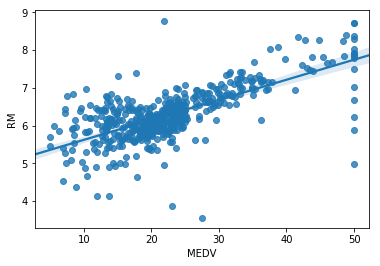

In [762]:
sns.regplot(data.MEDV, data.RM)

**Параметр MEDV имеет 'cap' на значении 50 тыс. Думаю, можно убрать из набора такие значения, чтобы они не искажали результат**

In [695]:
data_new = data[data.MEDV<50]
data_new.shape

(490, 14)

In [682]:
X = data_new.drop('MEDV', axis=1)
y = data_new.MEDV

In [704]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

scaler = StandardScaler()
models = {}
grids = {}

In [741]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(weights='uniform')
params = {'n_neighbors':range(1,10)}
models.update({'knn':{'model': knn, 'params': params}})

In [748]:
from sklearn.linear_model import Lasso

ridge = Lasso()
params = {'alpha':[1000, 100, 10, 1, 0.1, 0.01]}
models.update({'lasso':{'model': ridge, 'params': params}})

In [752]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
params = {'n_estimators':range(1,20, 1), 'max_depth':range(1, 20)}
models.update({'rfrst':{'model': rf, 'params': params}})

In [749]:
from sklearn.svm import SVR

svr = SVR(gamma='auto')
params = {'C':[100, 10, 1, 0.1, 0.01]}
models.update({'svr':{'model': svr, 'params': params}})

In [765]:
X_decr = pd.DataFrame(X, columns=dataset.feature_names)
X_decr.drop(['RAD', 'B', 'CHAS'], inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_decr, y, test_size=0.2, random_state=42)
X_tr_scaled = scaler.fit_transform(X_train)

In [766]:
print('Best MAE on training set:')
for k, v in models.items():
    grid = GridSearchCV(v.get('model'), v.get('params'), cv=5, scoring = 'neg_mean_absolute_error', iid=False)
    grid.fit(X_tr_scaled, y_train)
    grids.update({k: grid})
    print(k,'\t:{:.3f}'.format(-grid.best_score_))

print('\nBest MAE on validation set:')
for k, v in grids.items():
    print(k, '\t{:.3f}'.format(mean_absolute_error(v.best_estimator_.predict(scaler.transform(X_test)), y_test)))

print('\nBest R2 on validation set:')
for k, v in grids.items():
    print(k, '\t{:.3f}'.format(r2_score(v.best_estimator_.predict(scaler.transform(X_test)), y_test)))

Best MAE on training set:
knn 	:2.477
lasso 	:3.037
rfrst 	:2.151
svr 	:2.074

Best MAE on validation set:
knn 	2.423
lasso 	2.829
rfrst 	1.920
svr 	1.978

Best R2 on validation set:
knn 	0.708
lasso 	0.662
rfrst 	0.835
svr 	0.813


**Лучшие резултаты представлены вывше. Ошибка в 2 тыс. долларов может быть критичной**